In [1]:
import scipy.io
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('all_faults.csv')

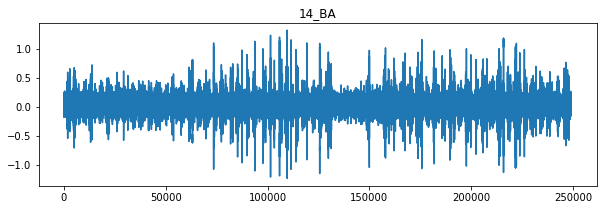

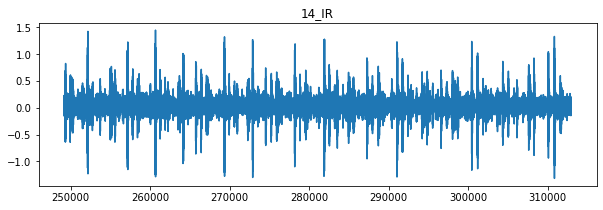

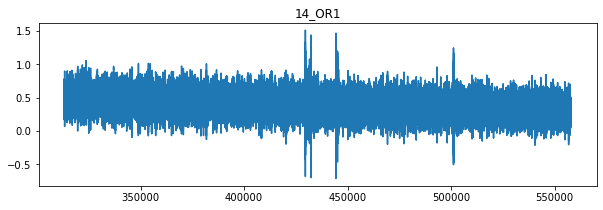

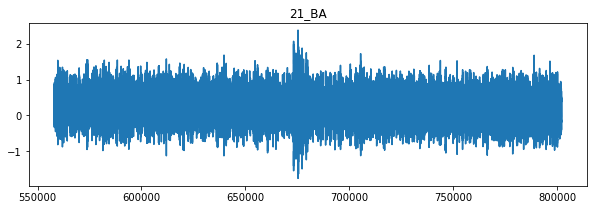

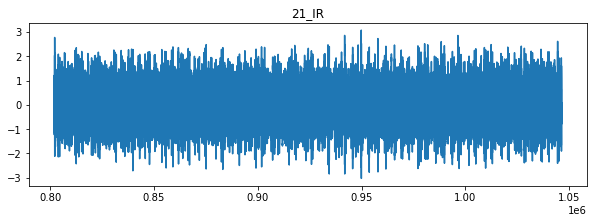

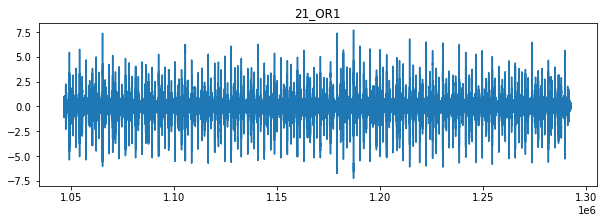

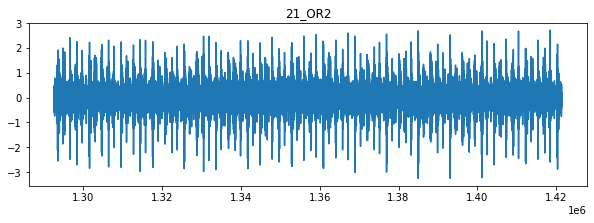

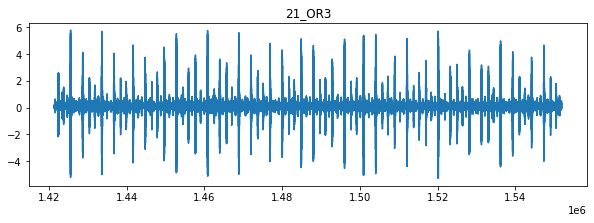

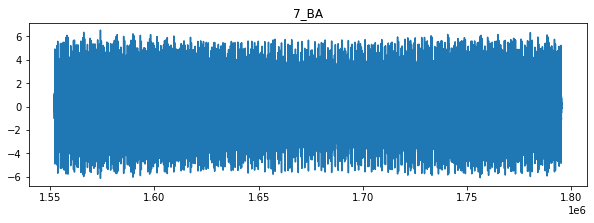

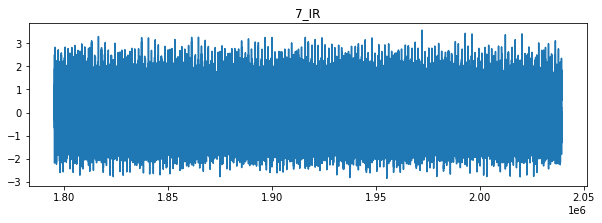

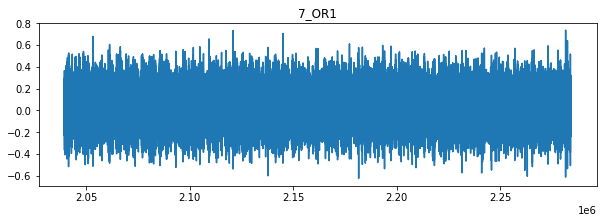

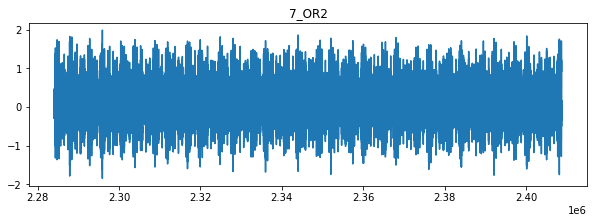

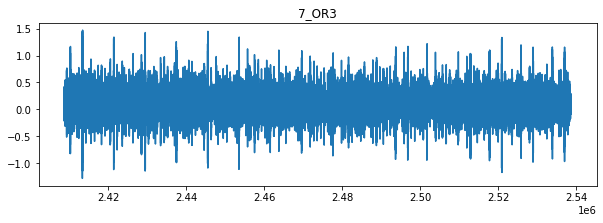

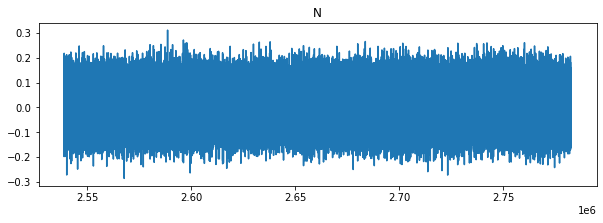

In [4]:
faults = df['fault'].unique()
for  f in faults:
    plt.figure(figsize=(10,3))
    plt.plot(df[df['fault']==f].iloc[:,0])
    plt.title(f)
    plt.show()

In [37]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

win_len=784
stride=300

X=[]
Y=[]


for k in df['fault'].unique():
    
    df_temp_2 = df[df['fault']==k]
    
    for i in np.arange(0,len(df_temp_2)-(win_len),stride):
        temp = df_temp_2.iloc[i:i+win_len,:-1].values
        temp = temp.reshape((1,-1))
        X.append(temp)
        Y.append(df_temp_2.iloc[i+win_len,-1])
    
X=np.array(X)
X=X.reshape((X.shape[0],28,28,1))
#X = np.repeat(X, 3, axis=3) # To repeat into 3 chanel format


Y=np.array(Y)
encoder= LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

In [38]:
X.shape

(9246, 28, 28, 1)

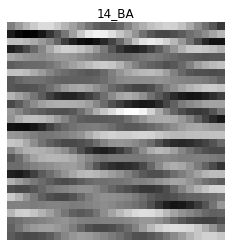

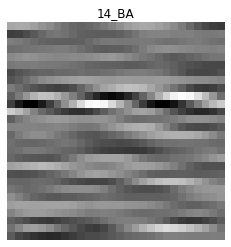

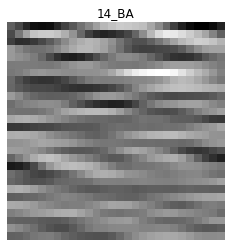

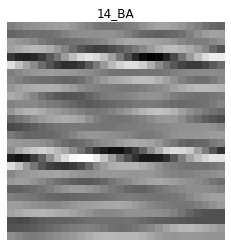

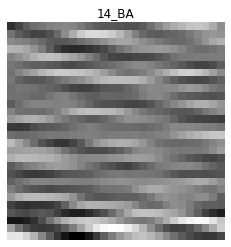

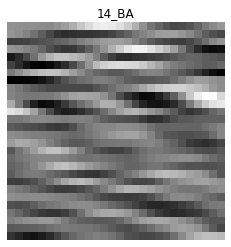

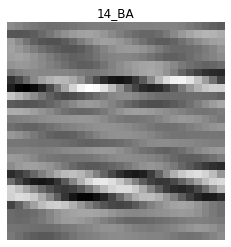

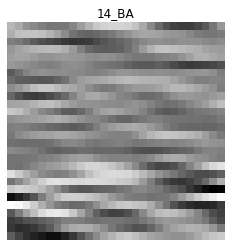

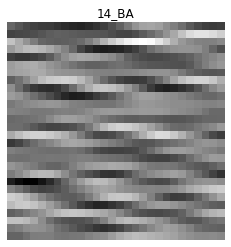

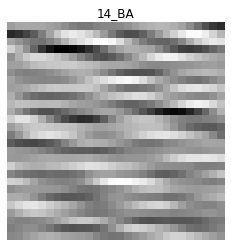

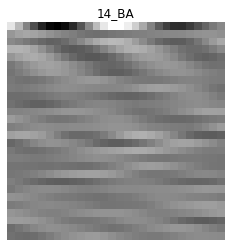

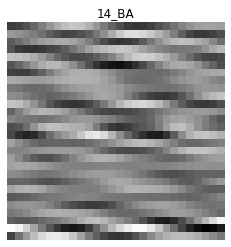

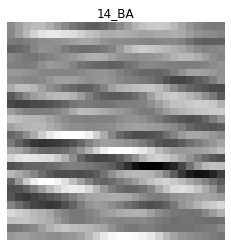

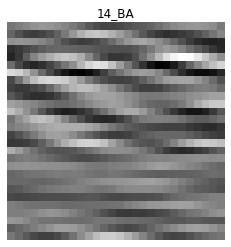

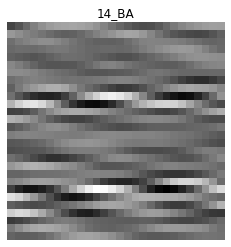

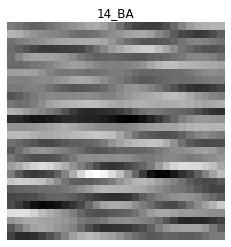

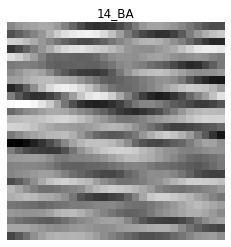

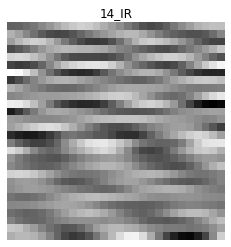

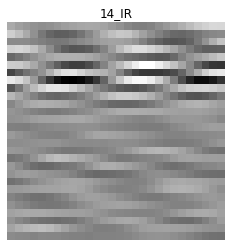

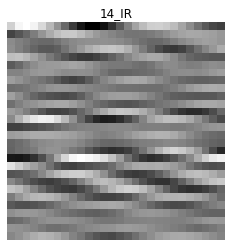

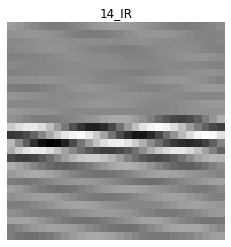

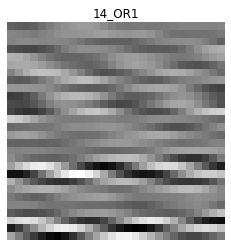

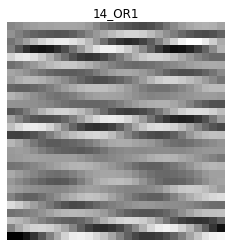

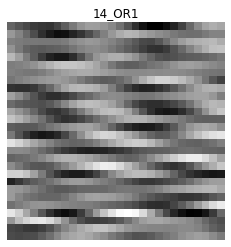

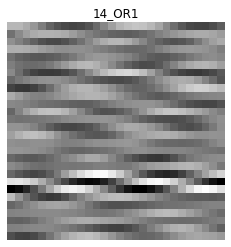

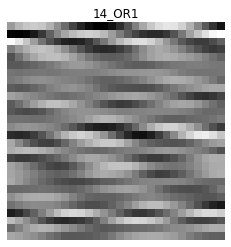

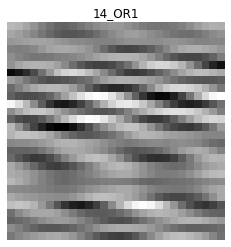

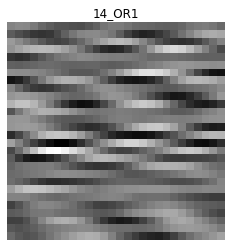

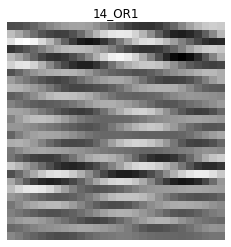

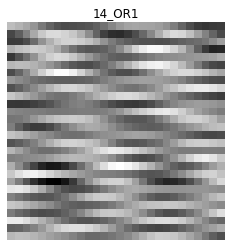

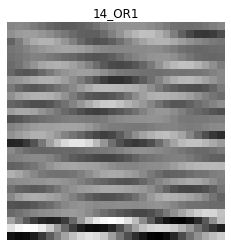

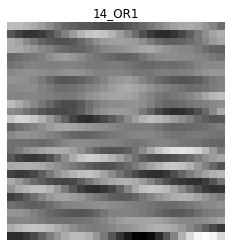

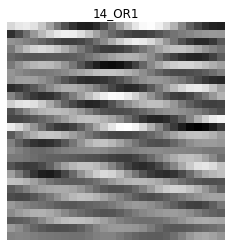

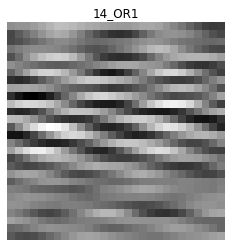

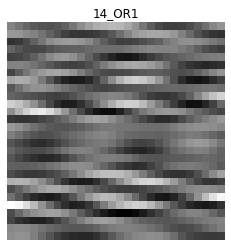

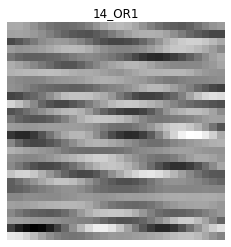

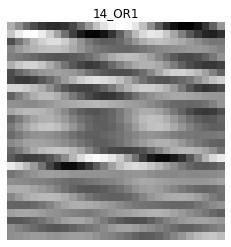

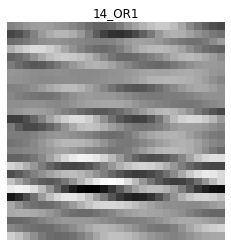

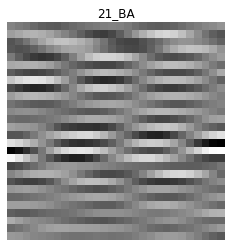

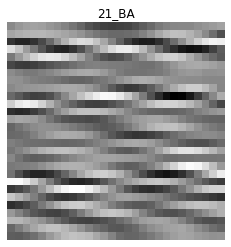

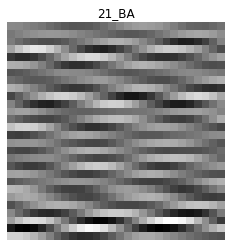

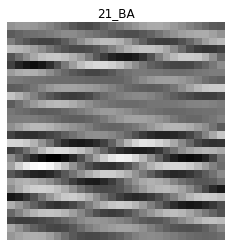

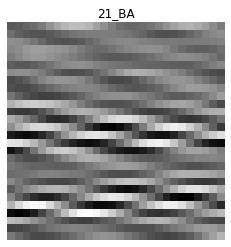

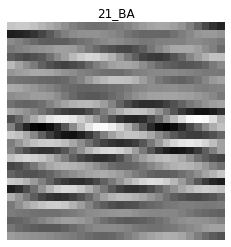

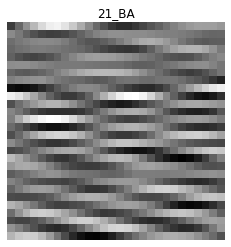

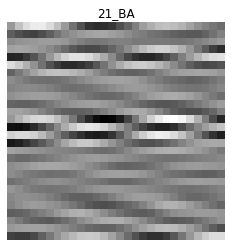

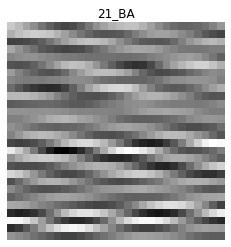

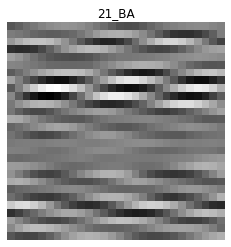

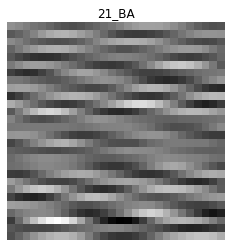

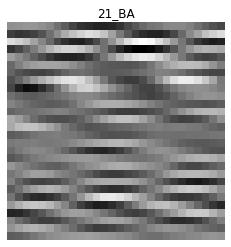

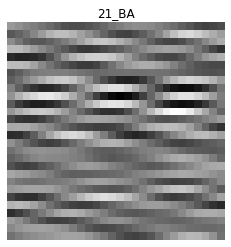

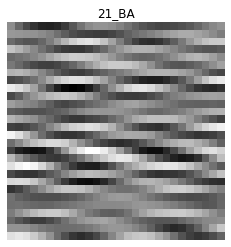

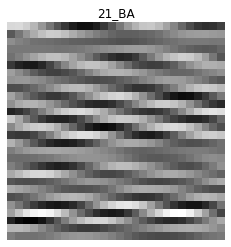

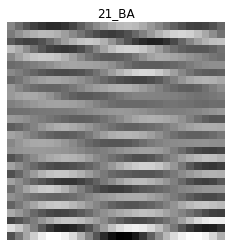

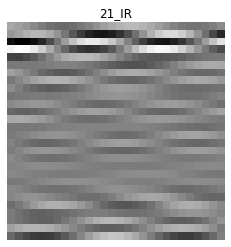

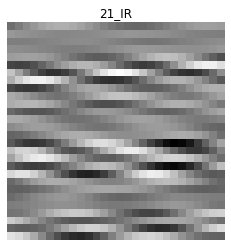

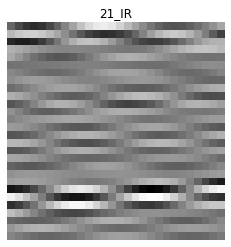

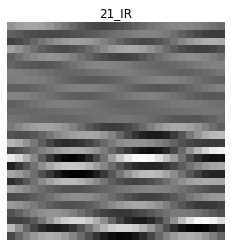

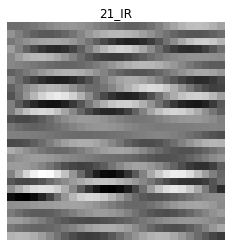

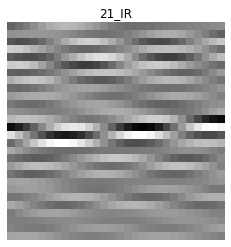

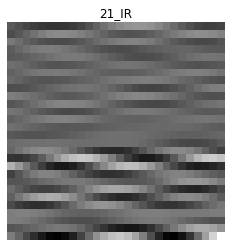

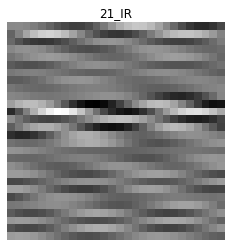

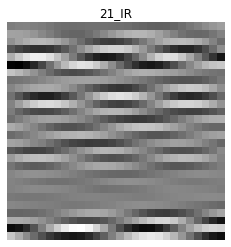

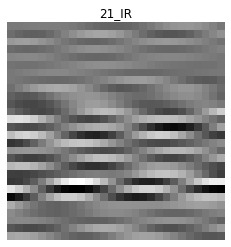

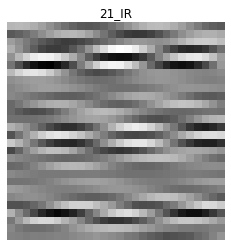

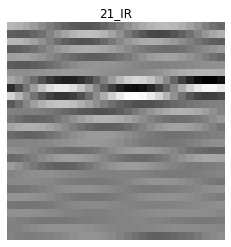

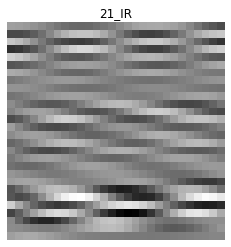

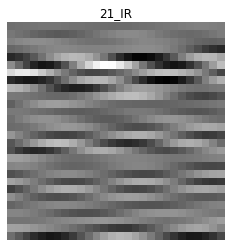

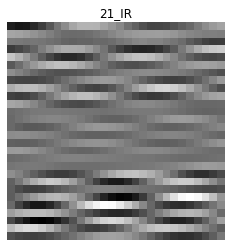

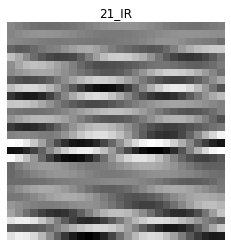

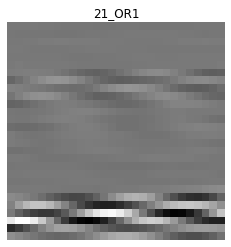

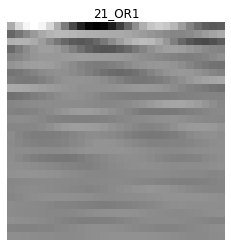

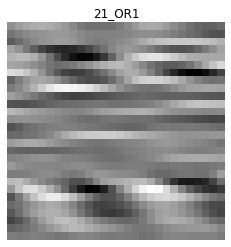

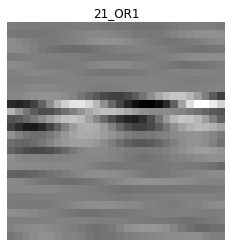

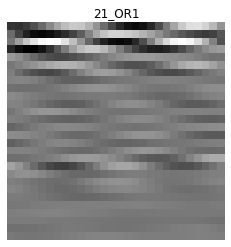

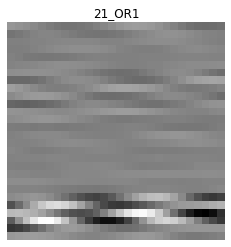

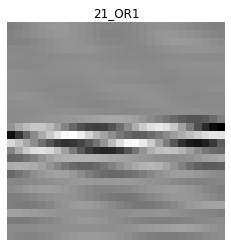

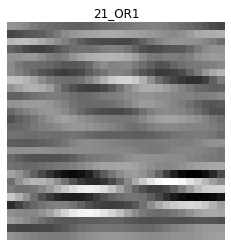

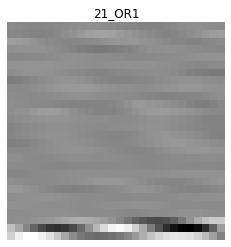

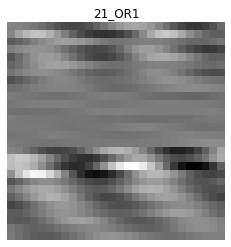

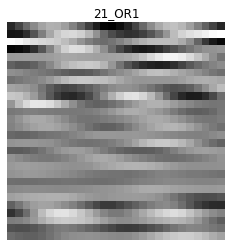

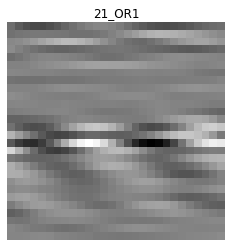

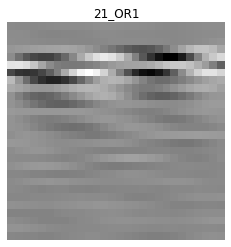

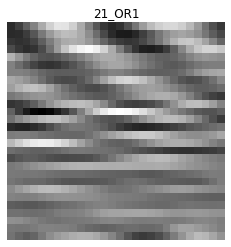

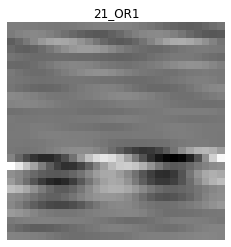

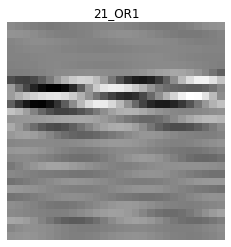

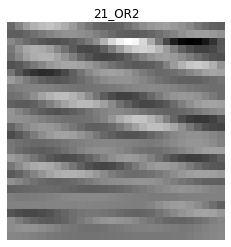

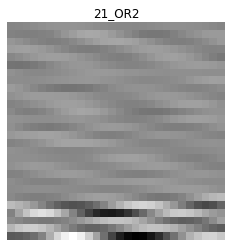

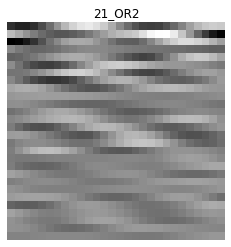

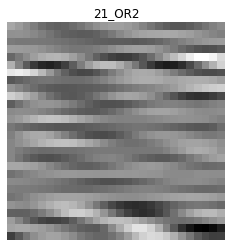

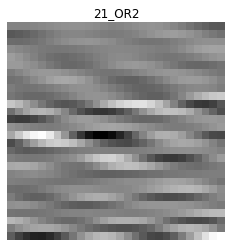

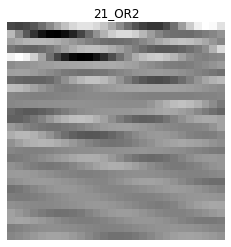

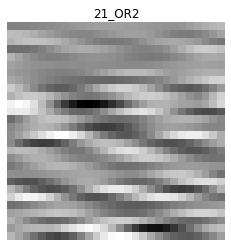

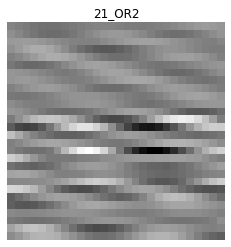

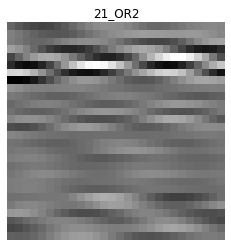

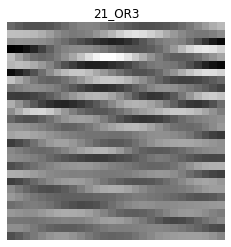

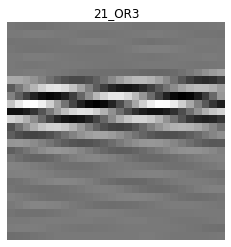

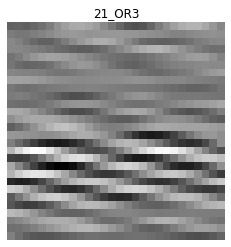

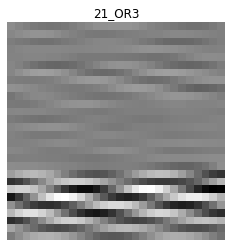

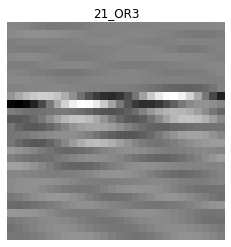

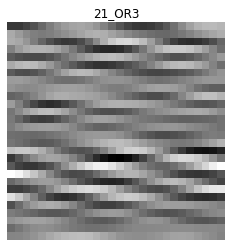

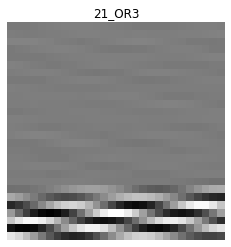

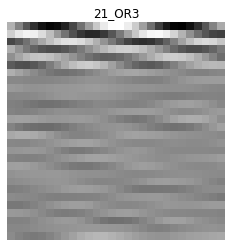

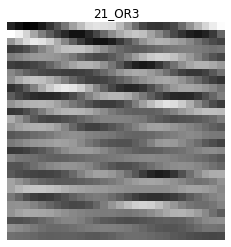

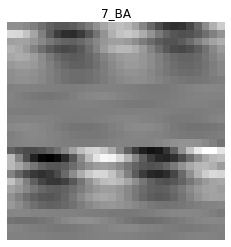

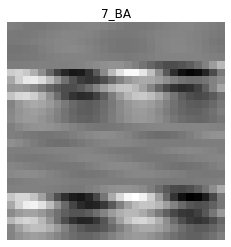

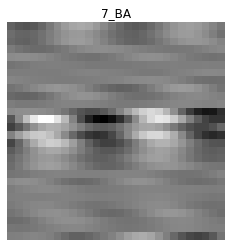

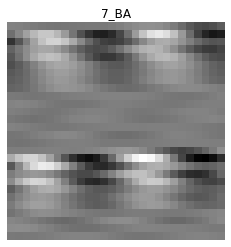

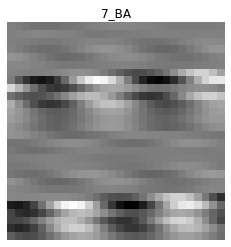

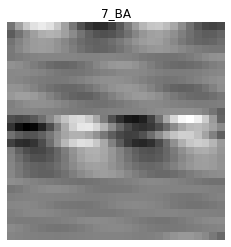

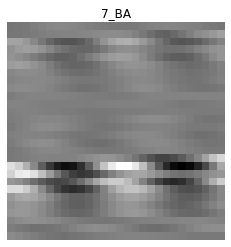

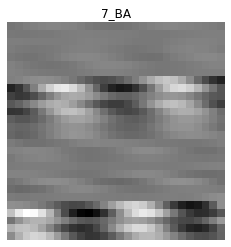

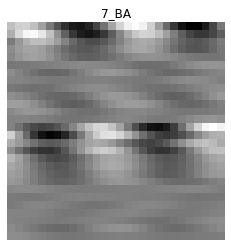

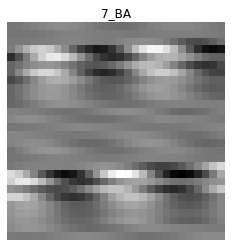

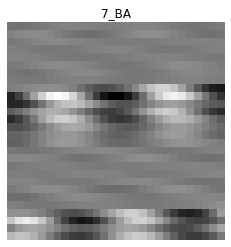

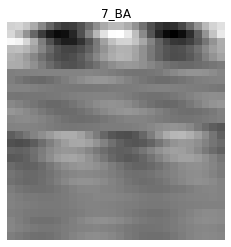

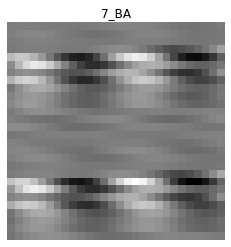

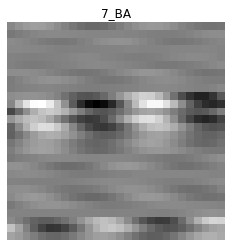

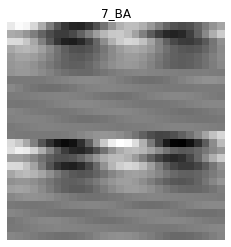

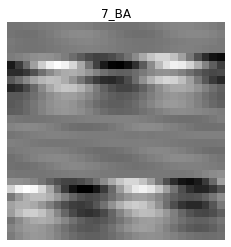

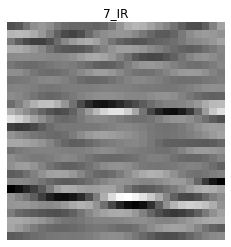

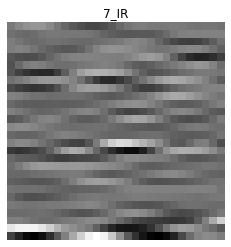

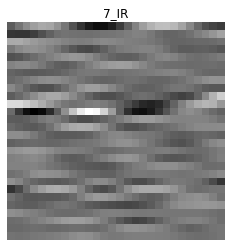

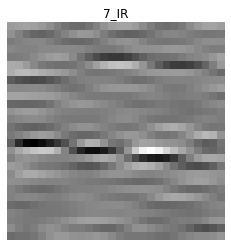

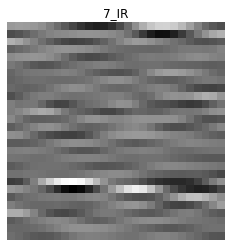

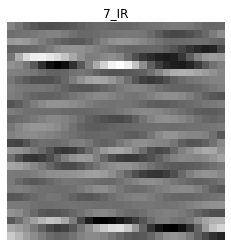

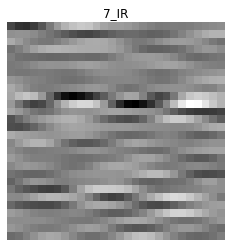

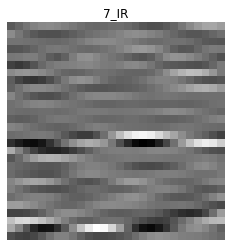

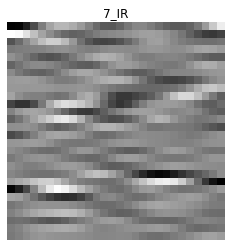

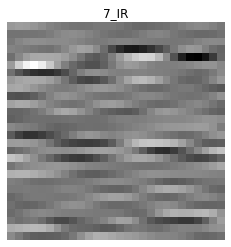

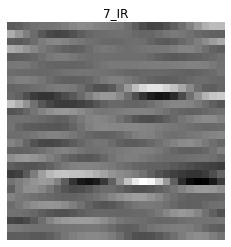

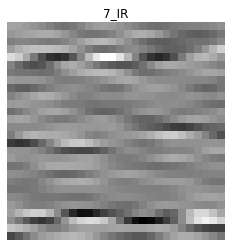

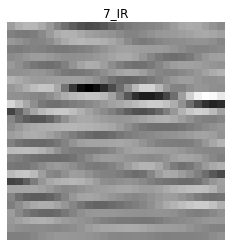

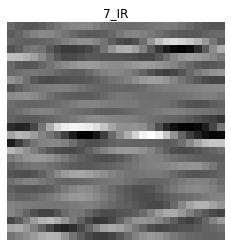

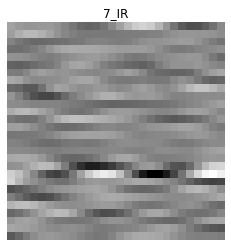

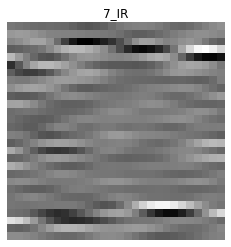

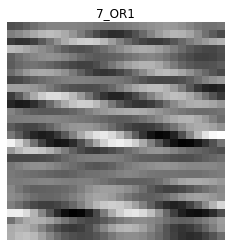

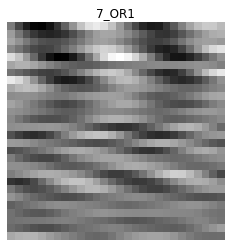

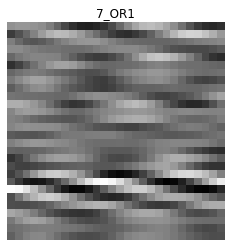

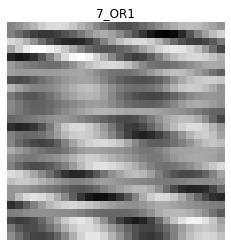

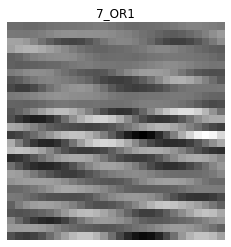

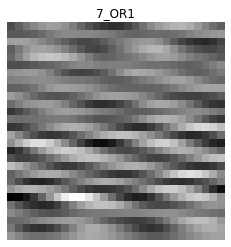

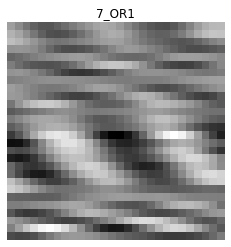

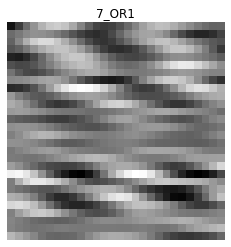

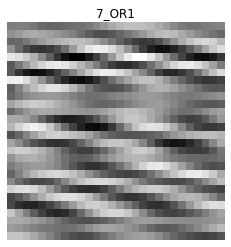

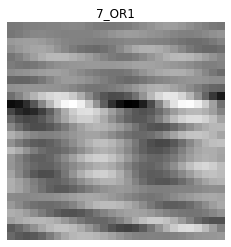

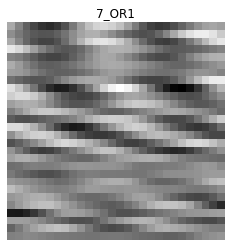

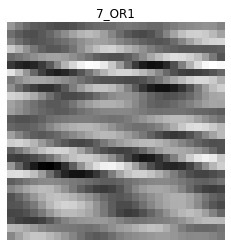

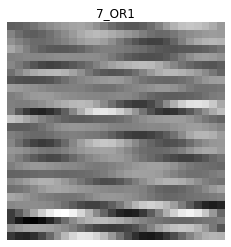

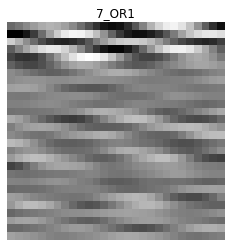

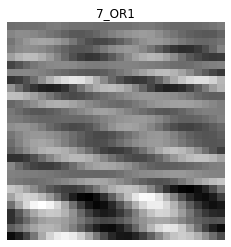

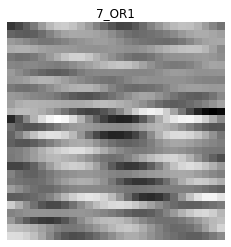

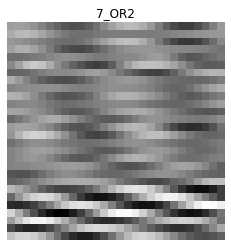

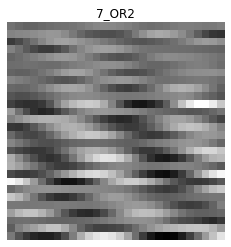

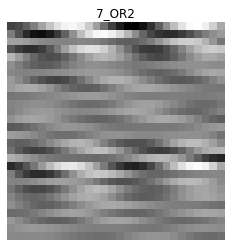

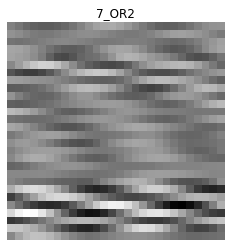

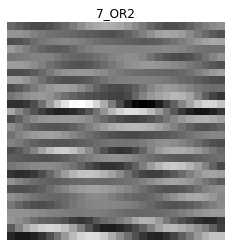

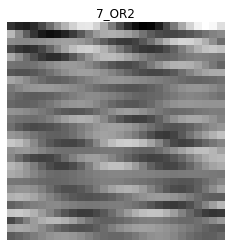

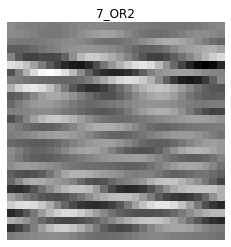

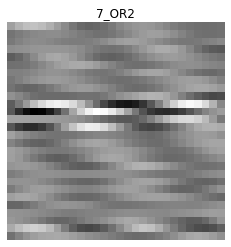

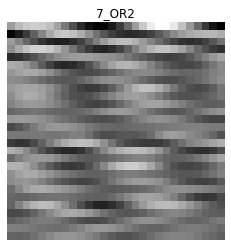

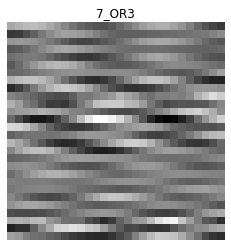

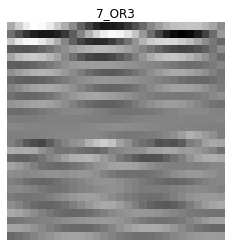

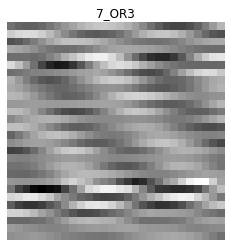

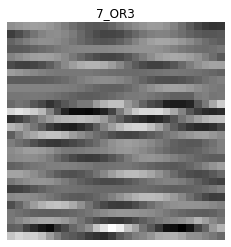

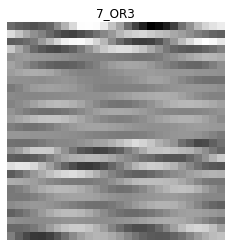

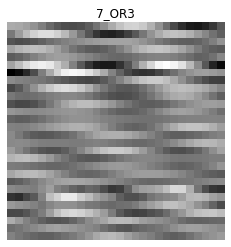

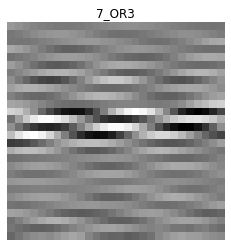

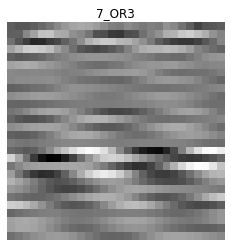

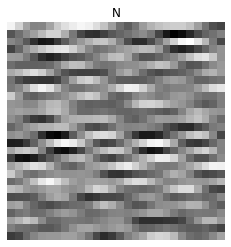

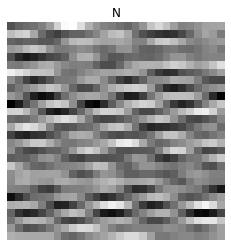

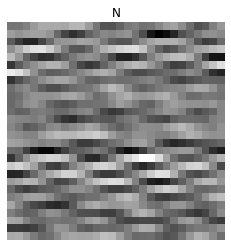

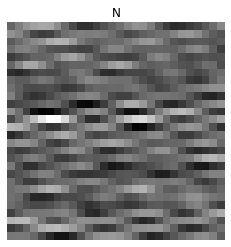

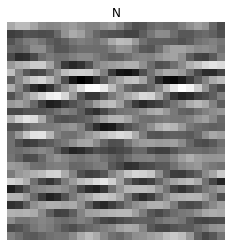

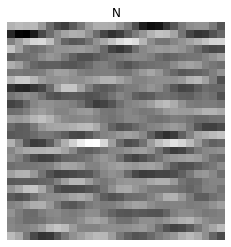

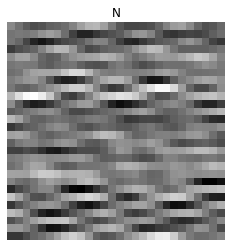

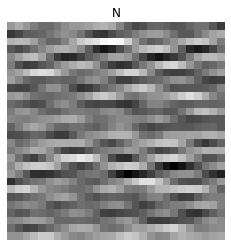

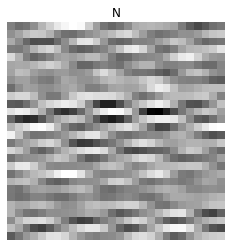

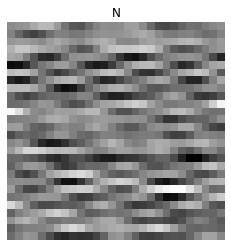

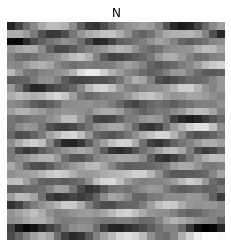

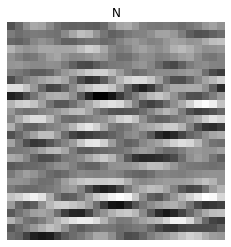

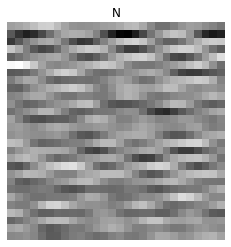

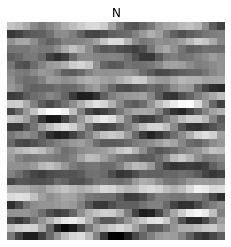

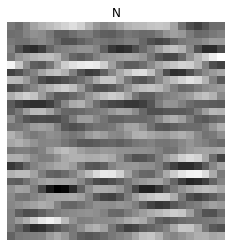

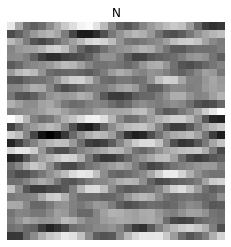

In [61]:
from matplotlib.pyplot import imread


for idx in range(0,9244,50):
    img=X[idx]

    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(Y[idx])
    plt.show()

In [39]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)


In [40]:
# X_pre_cnn = X.reshape(X.shape[0],X.shape[1]*X.shape[2])

# from sklearn.manifold import TSNE

# X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(X_pre_cnn)

# tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['t-SNE component 1', 't-SNE component 2'])

# tSNEdf['Fault']=Y


# # Plot the PC-1 and PC-2
# fig, ax = plt.subplots(figsize=(7,7))
# sns.scatterplot(x=tSNEdf['t-SNE component 1'],y=tSNEdf['t-SNE component 2'],hue='Fault',
#     data=tSNEdf,
#     legend="full",
#     alpha=0.3)
# plt.show()

In [41]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D



# from tensorflow.keras.models import load_model
# cnn_model = load_model(r'H:\Gear Fault\Trained Model\CNN_model_gear.h5')



no_classes = len(df['fault'].unique())

cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(20, 3),activation='relu',input_shape=(X.shape[1],X.shape[2],1),padding='same'))

cnn_model.add(MaxPooling2D((20, 2),strides=(5, 5),padding='same'))

cnn_model.add(Conv2D(64, (10, 3), activation='relu',padding='same'))

cnn_model.add(MaxPooling2D(pool_size=(10, 2),strides=(3, 3),padding='same'))

# cnn_model.add(Conv2D(128, (5, 3), activation='relu',padding='same'))
                 
# cnn_model.add(MaxPooling2D(pool_size=(5, 2),strides=(3, 3),padding='same'))

cnn_model.add(Flatten())

cnn_model.add(Dense(128, activation='relu'))
            
cnn_model.add(Dense(no_classes, activation='softmax'))

cnn_model.summary()

cnn_model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 28, 28, 32)        1952      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 6, 6, 64)          61504     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_13 (Dense)             (None, 14)               

In [43]:
batch_size = 400
epochs = 20
history = cnn_model.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_test,y_test),shuffle=True)

Epoch 1/20
17/17 [==============================] - 0s 26ms/step - loss: 0.0809 - accuracy: 0.9798 - val_loss: 0.0813 - val_accuracy: 0.9802
Epoch 2/20
17/17 [==============================] - 0s 26ms/step - loss: 0.0788 - accuracy: 0.9787 - val_loss: 0.0823 - val_accuracy: 0.9784
Epoch 3/20
17/17 [==============================] - 0s 25ms/step - loss: 0.0702 - accuracy: 0.9810 - val_loss: 0.0686 - val_accuracy: 0.9805
Epoch 4/20
17/17 [==============================] - 0s 26ms/step - loss: 0.0687 - accuracy: 0.9790 - val_loss: 0.0783 - val_accuracy: 0.9737
Epoch 5/20
17/17 [==============================] - 0s 26ms/step - loss: 0.0682 - accuracy: 0.9802 - val_loss: 0.0595 - val_accuracy: 0.9816
Epoch 6/20
17/17 [==============================] - 0s 25ms/step - loss: 0.0555 - accuracy: 0.9842 - val_loss: 0.0648 - val_accuracy: 0.9823
Epoch 7/20
17/17 [==============================] - 0s 26ms/step - loss: 0.0458 - accuracy: 0.9881 - val_loss: 0.0504 - val_accuracy: 0.9852
Epoch 8/20
17

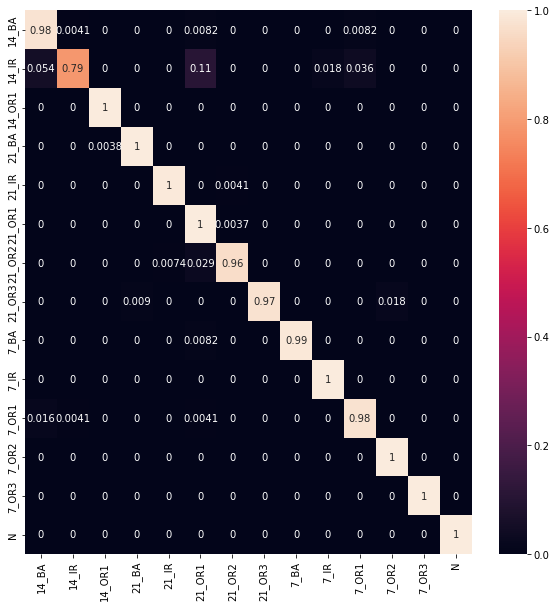

In [45]:
def inv_Transform_result(y_pred):    
    y_pred = y_pred.argmax(axis=1)
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred



y_pred=cnn_model.predict(X_test)


Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)




from sklearn.metrics import confusion_matrix


plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True,xticklabels=encoder.classes_,yticklabels=encoder.classes_)
plt.show()

In [46]:
dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[5].output)
y_viz = dummy_cnn.predict(X_train)

C:\Users\mohan\.conda\envs\tensorflow\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6472 samples in 0.000s...
[t-SNE] Computed neighbors for 6472 samples in 1.114s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6472
[t-SNE] Computed conditional probabilities for sample 2000 / 6472
[t-SNE] Computed conditional probabilities for sample 3000 / 6472
[t-SNE] Computed conditional probabilities for sample 4000 / 6472
[t-SNE] Computed conditional probabilities for sample 5000 / 6472
[t-SNE] Computed conditional probabilities for sample 6000 / 6472
[t-SNE] Computed conditional probabilities for sample 6472 / 6472
[t-SNE] Mean sigma: 1.469068
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.703430
[t-SNE] KL divergence after 300 iterations: 1.794145


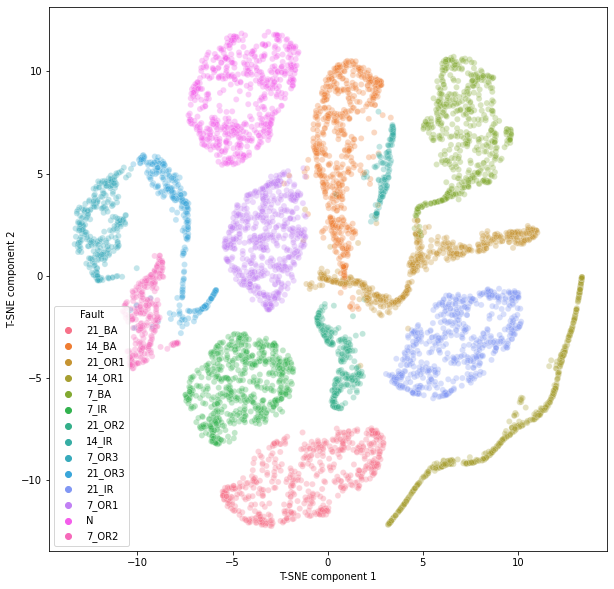

In [47]:
from sklearn.manifold import TSNE

X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['T-SNE component 1', 'T-SNE component 2'])

tSNEdf['Fault']=inv_Transform_result(y_train)


# Plot the PC-1 and PC-2
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=tSNEdf['T-SNE component 1'],y=tSNEdf['T-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()